In [1]:
# Importando os modulos

from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from nltk.stem.lancaster import LancasterStemmer
from nltk import word_tokenize
from numpy.random import shuffle
from numpy.random import randint
from numpy import array
from numpy import arange
import datetime
from os import path
import json

In [2]:
# baixando dependencia do nltk

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
# Montando o Armazenamento do Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Carregando base de dados
with open("/content/drive/My Drive/base.json", 'r') as json_file:
  data = dict(json.load(json_file))

In [5]:
# Preprando os dados

doc = []
words = []
target = []

stemmer = LancasterStemmer()

for key in data.keys():
    for r in data[key]['request']:
        w = word_tokenize(r)

        words.extend(w)
        doc.append((w, key))

    target.append(key)


words = sorted(list(set([stemmer.stem(w.lower()) for w in words if w not in ['?']])))

In [6]:
# Exibindo a resultado do processamento 

print(f"alvos -> {target}")
print(f"Previsores-> {words}")

alvos -> ['saudacao', 'despedida', 'agradecimento', 'nome', 'idade', 'horario', 'serviços', 'cursos', 'endereço', 'orçamento']
Previsores-> ['!', ',', 'a', 'abraço', 'abrem', 'ai', 'ajud', 'ajudou', 'alguem', 'alô', 'ano', 'at', 'atendimento', 'bem', 'boa', 'bom', 'catalago', 'como', 'curso', 'de', 'dia', 'dig', 'diz', 'endereço', 'escritorio', 'est', 'estou', 'eu', 'fav', 'faz', 'fazem', 'faço', 'ficam', 'funcionamento', 'gostar', 'hora', 'horario', 'idad', 'inform', 'informação', 'list', 'localização', 'mai', 'me', 'muito', 'mês', 'noit', 'nom', 'o', 'obrigado', 'oferecem', 'oi', 'ol', 'ond', 'os', 'par', 'pel', 'pod', 'poder', 'por', 'precisando', 'preciso', 'qua', 'qual', 'quanto', 'que', 'querendo', 'semest', 'serviço', 'seu', 'sua', 'tard', 'tchau', 'tem', 'teu', 'treinamento', 'treinameto', 'tudo', 'turm', 'um', 'voc', 'você', 'é']


In [7]:
# Normalizando os valores

dataset = []

for d in doc:
    predictors = []

    request = d[0]
    request = [stemmer.stem(w.lower()) for w in request]

    for w in words:
        predictors.append(1) if w in request else predictors.append(0)

    _target = [0] * len(target)
    _target[target.index(d[1])] = 1

    dataset.append([predictors, _target])

# Randomizando os valores
shuffle(dataset)

In [8]:
# Convertando os objetos para array numpy

x_train = []
y_train = []

for p, t in dataset:
    x_train.append(p)
    y_train.append(t)


x_train, y_train = (array(x_train), array(y_train))

In [9]:
# Criando o modelo

model = Sequential()

model.add(Dense(units=16, activation='sigmoid', kernel_initializer='random_uniform', input_dim=x_train.shape[1]))
model.add(BatchNormalization())
model.add(Dense(units=16, activation='sigmoid', kernel_initializer='random_uniform'))
model.add(BatchNormalization())
model.add(Dense(units=y_train.shape[1], activation='sigmoid', kernel_initializer='random_uniform'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

EarStop = EarlyStopping(monitor='loss', min_delta=1e-10, patience=20, verbose=1)
RedPlat = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=10, verbose=1)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 16)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dense_2 (Dense)              (None, 10)                170       
Total params: 1,914
Trainable params: 1,850
Non-trainable params: 64
_________________________________________________________________


In [10]:
# Classe que será responsavel por normalizar os elementos de entrada

class Parser:

    @staticmethod
    def __prepare(sentence: str) -> list:
        stemmer = LancasterStemmer()

        sentence_words = word_tokenize(sentence)
        sentence_words = [stemmer.stem(word.lower()) for word in sentence_words]

        return sentence_words

    @staticmethod
    def convert(sentence: str, words: list) -> array:

        _sentence: list = Parser.__prepare(sentence)
        predictors: list = [0] * len(words)

        for s in _sentence:
            for i, w in enumerate(words):
                if w == s:
                    predictors[i] = 1

        return array(predictors).reshape(1, -1)

In [11]:
# realizando o treinamento do modelo

history = model.fit(x_train, y_train, epochs=1000, batch_size=5, callbacks=[EarStop, RedPlat])

Epoch 1/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.6914 - binary_accuracy: 0.5417
Epoch 2/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.6831 - binary_accuracy: 0.7208
Epoch 3/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.6753 - binary_accuracy: 0.7667
Epoch 4/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.6656 - binary_accuracy: 0.7604
Epoch 5/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.6523 - binary_accuracy: 0.7625
Epoch 6/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.6403 - binary_accuracy: 0.7667
Epoch 7/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.6281 - binary_accuracy: 0.7833
Epoch 8/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.6129 - binary_accuracy: 0.7708
Epoch 9/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.5965 - binary_accuracy: 0.7833
Epoch 10/1000
10/10 [================

In [12]:
# Recuperando dados de treinamento

train_loss = history.history['loss']
train_steps = arange(len(history.history['loss'])) 

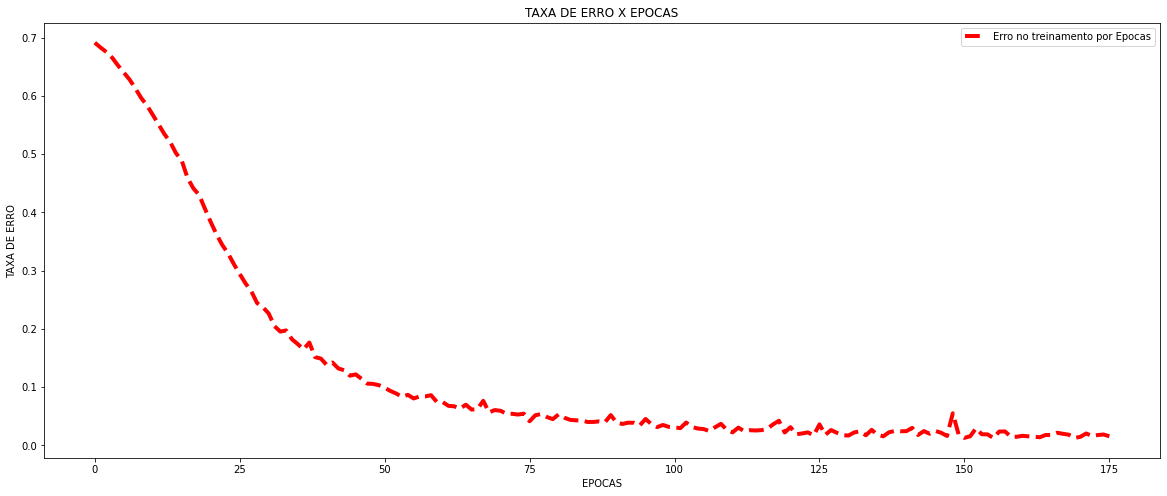

In [13]:
# Gerando grafico
plt.figure(figsize=(20, 8))

plt.plot(train_steps, train_loss, 'r--', label='Erro no treinamento por Epocas', linewidth=4)
plt.title('TAXA DE ERRO X EPOCAS')
plt.xlabel('EPOCAS')
plt.ylabel('TAXA DE ERRO')
plt.legend(loc='upper right')
plt.show()

In [14]:
# Função que será responsavel por traduzir a resposta do modelo

def talk(text):
  index = -1

  request = Parser.convert(text, words)
  resp = model.predict(request).round(0).astype('int')

  print(f"{text} -> {resp[0]}")
  if True in (resp == 1):
      index = resp.argmax()

  if index >= 0:
    w = data[target[index]]['response']
    w = w[randint(0, len(w))]

    print(w + "\n")
  else:
    print("Não consegui entender ':(\n")


In [17]:
# Testando o modelo
talk("ola")
talk("que horas vocês abrem?")
talk("o que vocês fazem")
talk("Quero um café")
talk("ok, obrigado!")
talk("tchau")

ola -> [1 0 0 0 0 0 0 0 0 0]
sim, posso te ajudar em algo?

que horas vocês abrem? -> [0 0 0 0 0 1 0 0 0 0]
Nosso horário de funcionamento é de segunda a sexta das 09:00 às 18:00

o que vocês fazem -> [0 0 0 0 0 0 1 0 0 0]
Oferecemos trainamentos e certificações em TI, nossa principal missão é agregar valor ao mercado profissional de Minas Gerais através da qualificação nas principais certificações nacionais e internacionais no setor de TI.

Quero um café -> [0 0 0 0 0 0 0 0 0 0]
Não consegui entender ':(

ok, obrigado! -> [0 0 1 0 0 0 0 0 0 0]
Fico feliz em ajudar!

tchau -> [0 1 0 0 0 0 0 0 0 0]
Tenha um otimo dia!

